Import libraries

In [22]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from metrics import print_evaluation_metrics

Load dataset and prepare df

In [23]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date_reported"
target_column = "New_deaths"
df = pd.read_csv(file_path, parse_dates=True)
df = df[[date_column, target_column]]

df.set_index(date_column, inplace=True)
df = df.groupby(date_column).sum().reset_index()

df = df.dropna()

Train test split

In [24]:
train = df.iloc[:-30]
test = df.iloc[-30:]

Parameter tuning for order

In [25]:
stepwise_fit = auto_arima(df[target_column], trace=True, suppress_warnings=True)
best_order = stepwise_fit.order

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=26527.083, Time=3.84 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=27442.044, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=27043.553, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=26540.935, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=27440.044, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=26494.719, Time=3.54 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=26546.835, Time=0.61 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=26538.677, Time=1.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=26511.422, Time=5.78 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=26521.824, Time=1.58 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=26558.943, Time=0.92 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=26392.763, Time=12.03 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=26388.049, Time=8.00 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=26466.856, Time=5.21 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=26368.501, Time=6.1

Create Model

In [26]:
model = ARIMA(train[target_column], order=best_order)
model = model.fit()
model.summary()

/home/samuell/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             New_deaths   No. Observations:                 1390
Model:                 ARIMA(5, 1, 5)   Log Likelihood              -12776.633
Date:                Sat, 09 Dec 2023   AIC                          25575.265
Time:                        14:04:09   BIC                          25632.865
Sample:                             0   HQIC                         25596.806
                               - 1390                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3187      0.035      9.147      0.000       0.250       0.387
ar.L2         -1.0611      0.032    -33.214      0.000      -1.124      -0.998
ar.L3          0.1357      0.042      3.228      0.001       0.053       0.218
ar.L4         -0.6045      0.030    -19.830      0.000      -0.664      -0.545
ar.L5         -0.4407      0.027    -16.414      0.000      -0.493      -0.388
ma.L1         -1.3775      0.036    -37.798      0.000      -1.449      -1.306
ma.L2          1.6981      0.052     32.665      0.000       1.596       1.800
ma.L3         -1.5397      0.052    -29.752      0.000      -1.641      -1.438
ma.L4          1.2131      0.038     32.237      0.000       1.139       1.287
ma.L5         -0.5511      0.027    -20.625      0.000      -0.603      -0.499
sigma2      8.667e+06   5.63e+04    153.899      0.000    8.56e+06    8.78e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):           5885419.96
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               2.95   Skew:                            12.36
Prob(H) (two-sided):                  0.00   Kurtosis:                       320.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Plot the result

/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: >

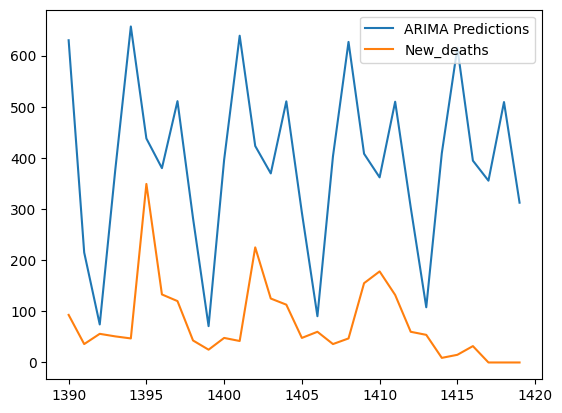

In [27]:
start = len(train)
end = len(train) + len(test) - 1
pred = model.predict(start=start, end=end, typ="levels").rename("ARIMA Predictions")
pred.plot(legend=True)
test[target_column].plot(legend=True)

RMSE of the result

In [28]:
print_evaluation_metrics(pred, test[target_column])

Evaluation Metrics:
MSE: 126103.94
RMSE: 355.11
MAE: 311.35
MAPE: inf
SMAPE: 130.06
